In [1]:
%matplotlib inline
import sys
sys.path.insert(0, "../..")

<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/jp/vit/examples/LodeSTAR/10.measure_mass_cell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

In [2]:
import random

import deeptrack as dt
import deeptrack.extras
import numpy as np
import skimage.color
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io

deeptrack.extras.datasets.load("CellData")

Dataset already downloaded.


In [3]:
import numpy as np
import matplotlib.pyplot as plt

crop_size = 64
padding = 32
wavelength = 633e-9 
pixel_size = 114e-9
crop_propagation_forward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, 1e-7, pixel_size * 2, wavelength)
crop_propagation_backward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, -1e-7, pixel_size * 2, wavelength)

experimental_data = np.load(r'datasets/CellData/shifted_cell_data.npy', allow_pickle=True)

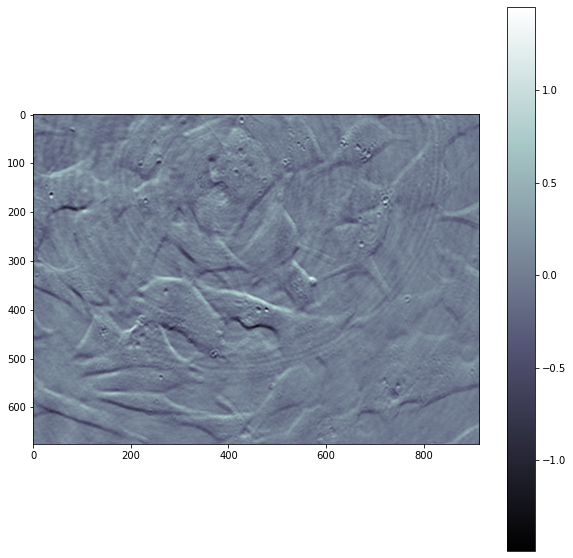

In [4]:
plt.figure(figsize=(10, 10))
plt.imshow(experimental_data[30, ..., 1], cmap="bone")
plt.colorbar()

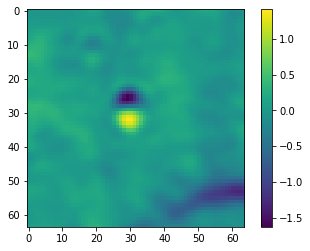

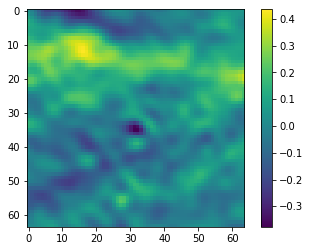

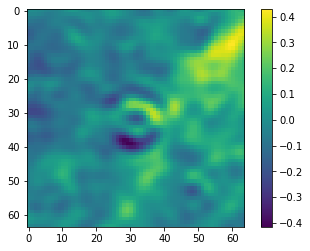

In [5]:
ds = 2
crs = 64

# Only the first crop is used in the paper.
crops = [
    (0, (310 - 32) // 2, (40 - 32) // 2),
    (30, 400, 537),
    (10, (1070 - 32) // 2, (950 - 32) // 2 ),
    
]

training_images = []

for t, x, y in crops:
    im = experimental_data[t, x:x+crs, y:y+crs]
    training_images.append(im)
    plt.imshow(im[..., 1])
    plt.colorbar()
    plt.show()



In [6]:
args = dt.Arguments(
    translate=lambda: np.random.randn(2) * 1,
    rotate=lambda:np.random.uniform(0, np.pi*2),
    z=lambda: np.random.uniform(-10, 10),
    rescale=lambda: 10**np.random.uniform(-0.5, 0.5)
)

group = ( 
     dt.Affine(rotate=args.rotate) 
    >>dt.Affine(translate=args.translate) 
    >> dt.Add(np.array([1, 0]))
    >> dt.Rescale(args.rescale)
    >> dt.Subtract(np.array([1, 0]))
    >> dt.FourierTransform() 
    >> dt.FourierTransformTransformation(crop_propagation_forward, crop_propagation_backward, args.z) 
    >> dt.InverseFourierTransform() 
    >> dt.Add(lambda: np.random.randn(1, 1, 2) * 0.05)
)
group = group[8:-8, 8:-8]

equivariance = (

    dt.models.lodestar.Rotational2DEquivariance(args.rotate)
    >> dt.models.lodestar.TranslationalEquivariance(args.translate)
    
    # >> dt.models.lodestar.Equivariance(1, args.z / 10, indexes=2)
    >> dt.models.lodestar.Equivariance(1, lambda arg: np.log(arg), arg = args.rescale, indexes=2)
)

In [18]:
import random
training_set = dt.Value(lambda: np.array(random.choice(training_images)))
generator = dt.models.lodestar.LodeSTARGenerator(
    training_set,
    3,
    (group, equivariance), 
    batch_size=8, 
    min_data_size=400, 
    max_data_size=501
)



In [19]:

with generator:
    model = dt.models.LodeSTAR(input_shape=(None, None, 2), num_outputs=3)
    model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())
    model.fit(generator, epochs=100, steps_per_epoch=100)


Generating 401 / 400 samples before starting training
Epoch 1/100
100/100 [==============================] - 3s 14ms/step - total_loss: 2.4753 - consistency_loss: 1.8497
Epoch 2/100
100/100 [==============================] - 1s 14ms/step - total_loss: 2.1616 - consistency_loss: 1.4892
Epoch 3/100
100/100 [==============================] - 1s 14ms/step - total_loss: 1.1477 - consistency_loss: 0.6479
Epoch 4/100
100/100 [==============================] - 1s 14ms/step - total_loss: 0.5259 - consistency_loss: 0.2362
Epoch 5/100
100/100 [==============================] - 1s 14ms/step - total_loss: 0.3464 - consistency_loss: 0.1116
Epoch 6/100
100/100 [==============================] - 1s 14ms/step - total_loss: 0.2815 - consistency_loss: 0.0688 1s
Epoch 7/100
100/100 [==============================] - 1s 14ms/step - total_loss: 0.2452 - consistency_loss: 0.0588
Epoch 8/100
100/100 [==============================] - 1s 14ms/step - total_loss: 0.2256 - consistency_loss: 0.0479
Epoch 9/100
100

In [9]:
# exp_data = experimental_data
# dets = model.predict_and_detect(exp_data, alpha=.05, beta=.95, cutoff=1.0, mode="constant")

# plt.figure(figsize=(10, 10))
# plt.imshow(exp_data[0, ..., 1], cmap="bone")
# plt.scatter(dets[0][:, 1], dets[0][:, 0], s=200, facecolor="none", linewidths=3, edgecolors="g")
# plt.show()
    

In [10]:
# fluo = np.load(r"datasets/CellData/cell_fluo_mask.npy")


# t = 0

# plt.figure(figsize=(10, 10))
# plt.imshow(fluo[t])
# plt.scatter(dets[t][:,1]*1, dets[t][:, 0]*1.005 - 5)
# plt.show()

# plt.figure(figsize=(10, 10))
# plt.imshow(exp_data[t,...,1])
# plt.scatter(dets[t][:,1], dets[t][:, 0])
# plt.show()
# # plt.imshow(exp_data[1, ..., 1])
# # plt.show()

In [11]:

# traces = []
# for idx in range(len(dets)):

#     connections = []
#     connected_observations = []
#     # Trace doroplets
#     for idy, trace in enumerate(traces):

#         last_frame, *pos = trace[-1]
#         if idx - last_frame > 4:
#             continue

#         for idz, new_pos in enumerate(dets[idx]):
#             distance = np.sqrt(np.square(new_pos[:2] - pos[:2]).sum())
            
#             if (
#                 distance < 5 and idz not in connected_observations
#             ):
#                 connected_observations.append(idz)
#                 trace.append(np.array((idx, *new_pos)))

#     detections = [p for i, p in enumerate(dets[idx]) if i not in connected_observations]

#     # Initiate new traces
#     for det in detections:
#         traces.append([np.array((idx, *det))])

# # traces = list(filter(lambda t: len(t) > , traces))

# len(traces)

In [12]:
# _traces = list(map(np.array, traces))
# _traces = list(filter(lambda t: len(t) > 10, _traces))
# for trace in _traces:
#     plt.plot(trace[:, 2], trace[:, 1])
# plt.axis("square")
# plt.show()


In [13]:
# import seaborn
# cl = []
# for d in _traces:
#     s = 0
#     for _d in d:
#         t, x, y =_d[0], _d[1]*1.005 - 5, _d[2]
#         try:
#             s += np.max(fluo[int(t), int(x)-0:int(x)+1, int(y)-0:int(y)+1])
#         except ValueError:
#             pass
#     s /= len(d)
#     if s > 0.5:
#         cl.append(1)
#     else:
#         cl.append(0)

# from IPython import display

# c1 = seaborn.color_palette("colorblind")[3]
# c2 = seaborn.color_palette("colorblind")[9]
# for t, frame in enumerate(exp_data):
#     if t % 10:
#         continue
#     plt.figure(figsize=(10, 10))
#     plt.imshow(exp_data[t, :, :, 1], cmap="bone", vmin=-1, vmax=1)
#     plt.axis("off")
    
#     for j, (trace, c) in enumerate(zip(_traces, cl)):
#         trace = np.array(trace)
#         if np.any(trace[:, 0] == t):
#             sub_trace = trace[(trace[:, 0] > t - 100) & (trace[:, 0] <= t)]
            
#             plt.scatter(sub_trace[-1, 2], sub_trace[-1, 1], s=150, facecolor="none", linewidths=3, edgecolors=c1 if c else c2)
#     display.clear_output(wait=True)
#     plt.show()

In [14]:
# out = np.zeros((0,))
# outa = np.zeros((0,))
# outb = np.zeros((0,))
# for d in _traces:

#     s = 0
#     for _d in d:
#         t, x, y =_d[0], _d[1]*1.005 - 5, _d[2]
#         try:
#             s += np.max(fluo[int(t), int(x):int(x)+1, int(y):int(y)+1])
#         except ValueError:
#             pass
#     s /= len(d)
#     vals = dt.convolve(d[:, 3], np.ones((25,))/25)[::25]
#     if s== 1:
#         outa = np.concatenate((outa, vals), axis=0)
#     elif s == 0:
#         outb = np.concatenate((outb, vals), axis=0)

#     out = np.concatenate((out, vals), axis=0)


# import seaborn

# ps_in_cell = 0.228**3*(1.58 - 1.39) / (1.39 * 2 + 1.58)
# ps_in_water = 0.228**3*(1.58 - 1.393) / (1.33* 2 + 1.58)

# # In the paper, we used a separate calibration set
# norm_factor = ps_in_cell / np.median(np.exp(outa))

# plt.figure(figsize=(5, 5))

# plt.hist(np.exp(outb) * norm_factor, 40, range=(0, ps_in_cell * 3), density=True, alpha=1, color=seaborn.color_palette("colorblind")[9], edgecolor="none")
# plt.hist(np.exp(outa) * norm_factor, 40, range=(0, ps_in_cell * 3), density=True, alpha=0.66, color=seaborn.color_palette("colorblind")[3], edgecolor="none")
# plt.yticks([])

0.17152537656432132
0.05088099501971877


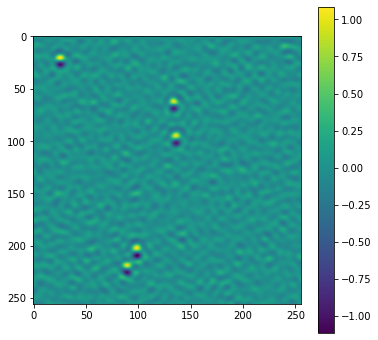

In [37]:
args = dt.Arguments(noise_level=lambda:10**np.random.uniform(-2, -1))

optics = dt.Brightfield(
    NA=1.3 / 4,
    wavelength=633e-9,
    magnification=1,
    resolution=0.114 * 2e-6,
    output_region=(0, 0, 256, 256),
    padding=(32, 32, 32, 32),
    return_field=True,
    illumination=dt.Gaussian(sigma=args.noise_level) >> dt.Gaussian(sigma=args.noise_level*1j)
)

mieparticle = dt.MieSphere(
    radius=250e-9,
    refractive_index=1.58,
    L=10,
    position=lambda: np.random.uniform(16, 224, 2),
    z=lambda: np.random.uniform(-1.5, 1.5, 1) * dt.units.um,
)


image_pipeline = optics(mieparticle ^ (lambda: np.random.randint(5, 10)))

offset = image_pipeline >> dt.Affine(translate=(0, 4))


pipeline = args >> (image_pipeline - offset)
pipeline.bind_arguments(args)


out = np.squeeze(pipeline.update()(noise_level=0.03))

# stack real and imag
# out = np.stack([np.real(out), np.imag(out)], axis=-1)

# detections = model.predict_and_detect(out[np.newaxis], alpha=0.5, beta=0.5, cutoff=0.8, mode="constant")
plt.figure(figsize=(6, 6))
plt.imshow(out.imag * 10)
plt.colorbar()
sq = np.sqrt(np.std(out.real) ** 2 + np.std(out.imag) ** 2)
print(sq / (0.2 * 0.36))
print(np.max(np.real(out)))
# plt.scatter(detections[0][:, 1], detections[0][:, 0], s=100, c="r")

In [38]:
signal = 0.05
noise_scale = 0.36

In [39]:

dataset = []
labels = []
noise_levels = []

for _ in range(5000):
    data = pipeline.update()().to_numpy()
    label = data.get_property("position", get_one=False)
    noise_level = data.get_property("noise_level")

    data = np.stack([np.real(data._value), np.imag(data._value)], axis=-1)
    data = np.squeeze(data)

    dataset.append(data)
    labels.append(label)
    noise_levels.append(noise_level)

<ipython-input-44-169cbe8a930a>:50: RuntimeWarning: invalid value encountered in true_divide
  f1 = 2 * noise_level_tp / (2 * noise_level_tp + noise_level_fp + noise_level_fn)


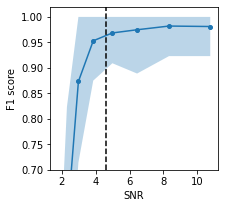

In [44]:
# import scipy
# alpha = 0.9
# beta = 1 - alpha
# cutoff = 0.03
# detections = model.predict_and_detect(np.array(dataset) * 2, alpha=alpha, beta=beta, cutoff=cutoff, mode="constant")

# noise_level_bins = np.logspace(-2, -1, 10)

# noise_level_tp = np.zeros_like(noise_level_bins)
# noise_level_fp = np.zeros_like(noise_level_bins)
# noise_level_fn = np.zeros_like(noise_level_bins)

# f1_arrs = [[] for _ in range(10)]


# for (det, label, noise_level) in zip(detections, labels, noise_levels):
#     label = np.array(label)
#     # Match detections with labels using a distance metric
#     dist = scipy.spatial.distance.cdist(det[:, :2], label)

#     # Solve using the Hungarian algorithm
#     row, col = scipy.optimize.linear_sum_assignment(dist)

#     # If distance is over 3 pixels, reject the match
#     mismatch = dist[row, col] > 10
#     row = row[~mismatch]
#     col = col[~mismatch]

#     # count TP and FP
#     tp = len(row)
#     fp = len(det) - tp

#     # count FN
#     fn = len(label) - tp


#     # Get noise level bin
#     noise_level_bin = np.digitize(noise_level, noise_level_bins)

#     # Update TP, FP, FN
#     noise_level_tp[noise_level_bin] += tp
#     noise_level_fp[noise_level_bin] += fp
#     noise_level_fn[noise_level_bin] += fn


#     f1_arrs[noise_level_bin].append(2 * tp / (2 * tp + fp + fn))

from matplotlib.ticker import ScalarFormatter

f1 = 2 * noise_level_tp / (2 * noise_level_tp + noise_level_fp + noise_level_fn)

# plot F1 score
plt.figure(figsize=(3, 3))

f1_low = [np.quantile(f1_arr, 0.90) if f1_arr else 0 for f1_arr in f1_arrs]
f1_high = [np.quantile(f1_arr, 0.1) if f1_arr else 0 for f1_arr in f1_arrs]

plt.plot(signal / ((noise_level_bins[:-1] * noise_scale)), f1[:-1], ".-", markersize=8, linewidth=1.5)

# plot shaded standard deviation
plt.fill_between(signal / ((noise_level_bins[1:-1] * noise_scale)), f1_low[1:-1], f1_high[1:-1], alpha=0.3)

plt.axvline(signal / (0.03 * noise_scale) , linestyle="--", color="k")
# plt.axvline(0.44 / 0.02 * 0.3 / 1.6, linestyle="--", color="k")


# remove scientific notation
formatter = ScalarFormatter()
formatter.set_scientific(False)
plt.gca().xaxis.set_major_formatter(formatter)



plt.xlabel("SNR")
plt.ylabel("F1 score")
plt.ylim(0.7, 1.02)
plt.savefig("f1_score_cells.svg")


In [41]:
noise_level_bins

array([0.01      , 0.0129155 , 0.01668101, 0.02154435, 0.02782559,
       0.03593814, 0.04641589, 0.05994843, 0.07742637, 0.1       ])

<ipython-input-42-2c39849d985c>:9: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(noise_level_bins, noise_level_fn / (noise_level_fn + noise_level_tp), ".-")
<ipython-input-42-2c39849d985c>:16: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(noise_level_bins, noise_level_fp / (noise_level_fp + noise_level_tp), ".-")


Text(0, 0.5, 'FPR')

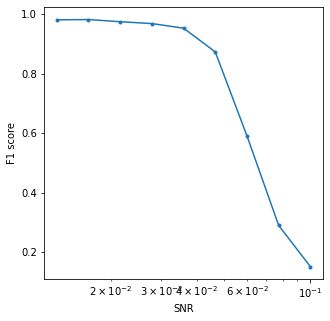

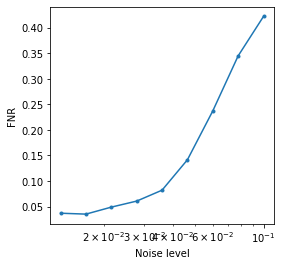

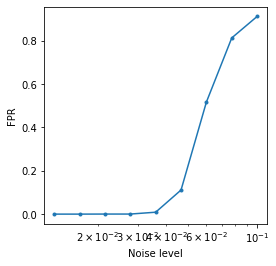

In [42]:
plt.figure(figsize=(5, 5))
plt.plot(noise_level_bins, f1, ".-")
plt.xscale("log")
plt.xlabel("SNR")
plt.ylabel("F1 score")

# Plot FNR and FPR
plt.figure(figsize=(4, 4))
plt.plot(noise_level_bins, noise_level_fn / (noise_level_fn + noise_level_tp), ".-")
plt.xscale("log")
plt.xlabel("Noise level")
plt.ylabel("FNR")

# Plot FPR
plt.figure(figsize=(4, 4))
plt.plot(noise_level_bins, noise_level_fp / (noise_level_fp + noise_level_tp), ".-")
plt.xscale("log")
plt.xlabel("Noise level")
plt.ylabel("FPR")



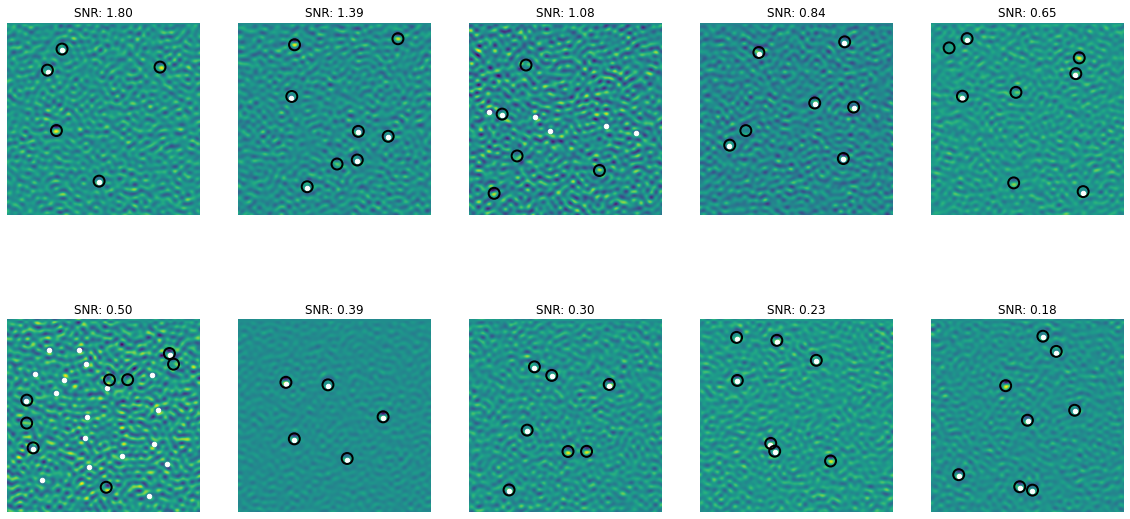

In [43]:
# show images in dataset and the detections

alpha = 0.9
beta = 1 - alpha
cutoff = 0.1
detections = model.predict_and_detect(np.array(dataset[:10]) * 2, alpha=alpha, beta=beta, cutoff=cutoff, mode="constant")


plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(dataset[i][:, :, 0])
    plt.scatter(detections[i][:, 1], detections[i][:, 0], s=20, c="w")
    plt.scatter(np.array(labels[i])[:, 1], np.array(labels[i])[:, 0], s=120, marker="o", facecolor="none", edgecolor="k", linewidth=2)
    plt.title(f"SNR: {signal / (noise_level_bins[i] / noise_scale):.2f}")
    plt.axis("off")

In [23]:
labels

[[array([137.93617574,  25.75538947]),
  array([ 70.11222289, 147.17218677]),
  array([ 58.78132468, 223.19356698]),
  array([47.28719824, 71.1606846 ]),
  array([137.34259797,  63.79477162]),
  array([219.68364029, 107.86784674])],
 [array([77.76946894, 91.84641934]),
  array([200.09626268, 138.72531777]),
  array([ 87.82299338, 152.72496817]),
  array([199.58506597, 168.57728372]),
  array([192.99729014, 177.2310237 ]),
  array([ 75.09205806, 205.22784947]),
  array([128.14133199, 112.21689224])],
 [array([21.36348678, 78.84782334]),
  array([143.49398003,  81.97483455]),
  array([108.32922472,  62.19932616]),
  array([199.83080767, 191.8727195 ]),
  array([108.20676832, 142.25607377]),
  array([ 22.90309508, 134.87187967]),
  array([57.81667164, 45.81341576])],
 [array([201.74147185, 211.86560519]),
  array([ 94.25269779, 211.57099575]),
  array([166.52839144,  59.87773133]),
  array([70.04823027, 23.11314443]),
  array([193.87308519,  92.41116971])],
 [array([ 91.0923125 , 220.5930